# PE4MOVE Data Preparation Pipeline

This notebook prepares the PE4MOVE dataset for machine learning analysis by:
1. Loading and exploring the raw data
2. Identifying intervention and control groups
3. Filtering participants with complete T1 (follow-up) data
4. Creating derived variables (motivation, self-monitoring)
5. Cleaning and selecting relevant attributes
6. Exporting separate CSV files for intervention and control groups

## 1. Import Libraries

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

## 2. Load Dataset

Load the PE4MOVE dataset and display basic information about its structure.

In [225]:
# Load the dataset
df = pd.read_csv('data/PE4MOVE_6MWT.csv')

print(f"Dataset shape: {df.shape}")
print(f"Participants: {len(df):,}")
print(f"Variables: {df.shape[1]}")
print(f"\nFirst few columns: {df.columns[:10].tolist()}")

Dataset shape: (3193, 381)
Participants: 3,193
Variables: 381

First few columns: ['Age', 'Sex', 'MVPA_Frequency_T0', 'MVPA_d0', 'MVPA_d1', 'MVPA_d2', 'MVPA_d3', 'MVPA_d4', 'MVPA_d5', 'MVPA_d6']


## 3. Identify Intervention and Control Groups

The dataset contains a `Group_Final` variable that indicates whether each participant was in Group A or Group B. We need to determine which group received the intervention by examining changes in MVPA (Moderate-to-Vigorous Physical Activity) frequency from T0 (baseline) to T1 (follow-up).

In [226]:
# Check group distribution
print("Group Distribution:")
print(df['Group_Final'].value_counts())
print(f"\nMissing group assignments: {df['Group_Final'].isna().sum()}")

# Compare MVPA changes between groups to identify intervention group
for group in ['A', 'B']:
    group_data = df[df['Group_Final'] == group]
    
    # Use only paired data (participants with both T0 and T1)
    paired_mask = group_data['MVPA_Frequency_T0'].notna() & group_data['MVPA_Frequency_T1'].notna()
    paired_data = group_data[paired_mask]
    
    t0_mean = paired_data['MVPA_Frequency_T0'].mean()
    t1_mean = paired_data['MVPA_Frequency_T1'].mean()
    change = t1_mean - t0_mean
    change_pct = (change / t0_mean * 100) if t0_mean > 0 else 0
    
    print(f"\nGroup {group} (n={paired_mask.sum()} paired):")
    print(f"  MVPA_Frequency_T0: {t0_mean:.2f}")
    print(f"  MVPA_Frequency_T1: {t1_mean:.2f}")
    print(f"  Change: {change:+.2f} ({change_pct:+.1f}%)")

print("\n" + "="*70)
print("CONCLUSION: Group A → INTERVENTION GROUP")
print("            Group B → CONTROL GROUP")
print("="*70)

Group Distribution:
Group_Final
A    2095
B    1098
Name: count, dtype: int64

Missing group assignments: 0

Group A (n=1007 paired):
  MVPA_Frequency_T0: 3.20
  MVPA_Frequency_T1: 3.49
  Change: +0.29 (+8.9%)

Group B (n=763 paired):
  MVPA_Frequency_T0: 3.05
  MVPA_Frequency_T1: 3.26
  Change: +0.21 (+6.9%)

CONCLUSION: Group A → INTERVENTION GROUP
            Group B → CONTROL GROUP


## 4. Split Dataset into Intervention and Control Groups

Based on the analysis above, we split the dataset into:
- **Intervention group** (Group A): Received the PE4MOVE program
- **Control group** (Group B): Did not receive the intervention

In [227]:
# Split into intervention and control groups
df_intervention = df[df['Group_Final'] == 'A'].copy()
df_control = df[df['Group_Final'] == 'B'].copy()

print(f"Intervention group (Group A): {len(df_intervention)} participants")
print(f"Control group (Group B): {len(df_control)} participants")

Intervention group (Group A): 2095 participants
Control group (Group B): 1098 participants


## 5. Filter Participants with Complete T1 Data

For our analysis, we only include participants who have complete follow-up (T1) data for MVPA frequency. This ensures we can measure the outcome of interest.

In [228]:
# Filter intervention group for complete T1 data
print("INTERVENTION GROUP:")
print(f"  Original: {len(df_intervention)} participants")
print(f"  Missing MVPA_Frequency_T1: {df_intervention['MVPA_Frequency_T1'].isna().sum()}")

df_intervention_clean = df_intervention[df_intervention['MVPA_Frequency_T1'].notna()].copy()
print(f"  After filtering: {len(df_intervention_clean)} participants")
print(f"  Retention rate: {len(df_intervention_clean)/len(df_intervention)*100:.1f}%")

# Filter control group for complete T1 data
print("\nCONTROL GROUP:")
print(f"  Original: {len(df_control)} participants")
print(f"  Missing MVPA_Frequency_T1: {df_control['MVPA_Frequency_T1'].isna().sum()}")

df_control_clean = df_control[df_control['MVPA_Frequency_T1'].notna()].copy()
print(f"  After filtering: {len(df_control_clean)} participants")
print(f"  Retention rate: {len(df_control_clean)/len(df_control)*100:.1f}%")

INTERVENTION GROUP:
  Original: 2095 participants
  Missing MVPA_Frequency_T1: 1088
  After filtering: 1007 participants
  Retention rate: 48.1%

CONTROL GROUP:
  Original: 1098 participants
  Missing MVPA_Frequency_T1: 335
  After filtering: 763 participants
  Retention rate: 69.5%


## 6. Create Derived Variables


### 6.1 Remove "Prefer not to say" Responses

We remove participants who selected "prefer not to say" for any relevant columns. Different columns use different numeric codes for this response (3, 6, 8, or 11).

In [229]:
def remove_prefer_not_to_say_values(df):
    """
    Remove rows where participants selected 'prefer not to say' for any relevant column.
    Different columns use different numeric codes for this response.
    """
    
    initial_count = len(df)
    
    # Define the mapping of columns to their "prefer not to say" values
    prefer_not_to_say_mapping = {
        # Value = 3
        'Sex': 3,
        
        # Value = 6
        'Leisure_Exercise_T0': 6,
        'Leisure_Exercise_T1': 6,
        'YAP_sedentary_general_T0': 6,
       
        'Leisure_PA_T0': 6,
        'Leisure_PA_T1': 6,
        'PE_hours_T0': 6,
       
        'Extracurricular_Session_Coach_T0': 6,
  
        'Extracurricular_Session_School_T0': 6,
       
        
        # Value = 8
        'MVPA_Frequency_T0': 8,
        'MVPA_Frequency_T1': 8,
        'MVPA_Usual_Week_T0': 8,
        'MVPA_Usual_Week_T1': 8,
        
        # Value = 11
        'COVID_impact_T0': 11,
    }
    
    # Add all Self_Monitoring columns (value = 6)
    for i in range(1, 5):
        prefer_not_to_say_mapping[f'Self_Monitoring_{i}_T0'] = 6
    
    # Add all Motivation-related columns (value = 6)
    motiv_types = ['Instrinsic', 'Identified', 'Extrinsic', 'Introjected']
    for motiv_type in motiv_types:
        for i in range(1, 5):
            prefer_not_to_say_mapping[f'Motiv_{motiv_type}_{i}_T0'] = 6
    
    # Add all Amotivation columns (value = 6)
    for i in range(1, 5):
        prefer_not_to_say_mapping[f'Amotivation_{i}_T0'] = 6
    
    # Create a mask for rows to keep (no "prefer not to say" values)
    mask = pd.Series([True] * len(df), index=df.index)
    removed_by_column = {}
    
    for col, pref_value in prefer_not_to_say_mapping.items():
        if col in df.columns:
            col_mask = df[col] == pref_value
            count = col_mask.sum()
            if count > 0:
                removed_by_column[col] = count
                mask &= ~col_mask
    
    # Apply the mask to remove rows
    df_cleaned = df[mask].copy()
    total_removed = initial_count - len(df_cleaned)
    
    # Print summary
    print(f"Removed participants with 'prefer not to say' responses:")
    print(f"  Initial participants: {initial_count}")
    print(f"  Participants removed: {total_removed}")
    print(f"  Remaining participants: {len(df_cleaned)}")
    print(f"  Retention rate: {len(df_cleaned)/initial_count*100:.1f}%")
    
    if removed_by_column:
        print(f"\n  Breakdown by column (rows with value = 'prefer not to say'):")
        for col, count in sorted(removed_by_column.items(), key=lambda x: x[1], reverse=True)[:10]:
            print(f"    {col}: {count} rows")
        if len(removed_by_column) > 10:
            print(f"    ... and {len(removed_by_column) - 10} more columns")
    print()
    
    return df_cleaned

# Remove "prefer not to say" responses from both datasets
print("INTERVENTION GROUP:")
df_intervention_clean = remove_prefer_not_to_say_values(df_intervention_clean)

print("CONTROL GROUP:")
df_control_clean = remove_prefer_not_to_say_values(df_control_clean)

INTERVENTION GROUP:
Removed participants with 'prefer not to say' responses:
  Initial participants: 1007
  Participants removed: 296
  Remaining participants: 711
  Retention rate: 70.6%

  Breakdown by column (rows with value = 'prefer not to say'):
    Amotivation_4_T0: 78 rows
    Self_Monitoring_3_T0: 70 rows
    Self_Monitoring_4_T0: 70 rows
    Self_Monitoring_1_T0: 69 rows
    Motiv_Instrinsic_4_T0: 69 rows
    Amotivation_1_T0: 67 rows
    Self_Monitoring_2_T0: 65 rows
    Amotivation_2_T0: 63 rows
    Motiv_Extrinsic_1_T0: 55 rows
    Amotivation_3_T0: 55 rows
    ... and 27 more columns

CONTROL GROUP:
Removed participants with 'prefer not to say' responses:
  Initial participants: 763
  Participants removed: 212
  Remaining participants: 551
  Retention rate: 72.2%

  Breakdown by column (rows with value = 'prefer not to say'):
    Amotivation_4_T0: 39 rows
    Motiv_Instrinsic_4_T0: 38 rows
    Self_Monitoring_1_T0: 37 rows
    Self_Monitoring_4_T0: 35 rows
    Motiv_Intro

In [230]:

print(f"Intervention group after cleaning: {df_intervention_clean.shape}")
print(f"Control group after cleaning: {df_control_clean.shape}")


Intervention group after cleaning: (711, 381)
Control group after cleaning: (551, 381)


### 6.2 Motivation Scores

We create overall motivation scores based on Self-Determination Theory:
- **Formula**: `((Intrinsic + Identified) / 2) - ((Extrinsic + Introjected + Amotivation) / 3)`
- Higher scores indicate more autonomous (self-determined) motivation
- Created for both T0 (baseline) and T1 (follow-up)

In [231]:
def create_motivation_scores(df):
    """Create overall motivation scores from individual components."""
    
    # Motivation_T0
    df['Motivation_T0'] = (
        (df['Motiv_Instrinsic_1_T0'] + df['Motiv_Instrinsic_2_T0'] + 
         df['Motiv_Instrinsic_3_T0'] + df['Motiv_Instrinsic_4_T0'] +
         df['Motiv_Identified_1_T0'] + df['Motiv_Identified_2_T0'] + 
         df['Motiv_Identified_3_T0'] + df['Motiv_Identified_4_T0']) / 2 -
        (df['Motiv_Extrinsic_1_T0'] + df['Motiv_Extrinsic_2_T0'] + 
         df['Motiv_Extrinsic_3_T0'] + df['Motiv_Extrinsic_4_T0'] +
         df['Motiv_Introjected_1_T0'] + df['Motiv_Introjected_2_T0'] + 
         df['Motiv_Introjected_3_T0'] + df['Motiv_Introjected_4_T0'] +
         df['Amotivation_1_T0'] + df['Amotivation_2_T0'] + 
         df['Amotivation_3_T0'] + df['Amotivation_4_T0']) / 3
    )
    
    # Motivation_T1
    df['Motivation_T1'] = (
        (df['Motiv_Instrinsic_1_T1'] + df['Motiv_Instrinsic_2_T1'] + 
         df['Motiv_Instrinsic_3_T1'] + df['Motiv_Instrinsic_4_T1'] +
         df['Motiv_Identified_1_T1'] + df['Motiv_Identified_2_T1'] + 
         df['Motiv_Identified_3_T1'] + df['Motiv_Identified_4_T1']) / 2 -
        (df['Motiv_Extrinsic_1_T1'] + df['Motiv_Extrinsic_2_T1'] + 
         df['Motiv_Extrinsic_3_T1'] + df['Motiv_Extrinsic_4_T1'] +
         df['Motiv_Introjected_1_T1'] + df['Motiv_Introjected_2_T1'] + 
         df['Motiv_Introjected_3_T1'] + df['Motiv_Introjected_4_T1'] +
         df['Amotivation_1_T1'] + df['Amotivation_2_T1'] + 
         df['Amotivation_3_T1'] + df['Amotivation_4_T1']) / 3
    )
    
    print(f"Created Motivation_T0: mean={df['Motivation_T0'].mean():.2f}, std={df['Motivation_T0'].std():.2f}")
    print(f"Created Motivation_T1: mean={df['Motivation_T1'].mean():.2f}, std={df['Motivation_T1'].std():.2f}")
    
    return df

# Create motivation scores for both groups
print("INTERVENTION GROUP:")
df_intervention_clean = create_motivation_scores(df_intervention_clean)

print("\nCONTROL GROUP:")
df_control_clean = create_motivation_scores(df_control_clean)

INTERVENTION GROUP:
Created Motivation_T0: mean=7.31, std=4.48
Created Motivation_T1: mean=5.94, std=5.19

CONTROL GROUP:
Created Motivation_T0: mean=7.08, std=4.51
Created Motivation_T1: mean=6.07, std=5.41


### 6.3 Self-Monitoring Scores

We create overall self-monitoring scores by averaging the 4 individual self-monitoring items for both T0 and T1.

In [232]:
def create_self_monitoring_scores(df):
    """Create overall self-monitoring scores from individual items."""
    
    # Self_Monitoring_T0: average of the 4 T0 items
    df['Self_Monitoring_T0'] = (
        df['Self_Monitoring_1_T0'] + df['Self_Monitoring_2_T0'] + 
        df['Self_Monitoring_3_T0'] + df['Self_Monitoring_4_T0']
    ) / 4
    
    # Self_Monitoring_T1: average of the 4 T1 items
    df['Self_Monitoring_T1'] = (
        df['Self_Monitoring_1_T1'] + df['Self_Monitoring_2_T1'] + 
        df['Self_Monitoring_3_T1'] + df['Self_Monitoring_4_T1']
    ) / 4
    
    print(f"Created Self_Monitoring_T0: mean={df['Self_Monitoring_T0'].mean():.2f}, std={df['Self_Monitoring_T0'].std():.2f}")
    print(f"Created Self_Monitoring_T1: mean={df['Self_Monitoring_T1'].mean():.2f}, std={df['Self_Monitoring_T1'].std():.2f}")
    
    return df

# Create self-monitoring scores for both groups
print("INTERVENTION GROUP:")
df_intervention_clean = create_self_monitoring_scores(df_intervention_clean)

print("\nCONTROL GROUP:")
df_control_clean = create_self_monitoring_scores(df_control_clean)

INTERVENTION GROUP:
Created Self_Monitoring_T0: mean=3.35, std=1.20
Created Self_Monitoring_T1: mean=3.59, std=1.27

CONTROL GROUP:
Created Self_Monitoring_T0: mean=3.22, std=1.22
Created Self_Monitoring_T1: mean=3.47, std=1.30


### 6.4 MVPA_Improvement Scores

Now we calculate MVPA improvement scores by finding the difference in MVPA frequency from T0 to T1. This calculation happens after cleaning "prefer not to say" values, so those responses are properly excluded.

In [233]:
def calculate_mvpa_improvement(df):

    df['MVPA_Improvement'] = df['MVPA_Frequency_T1'] - df['MVPA_Frequency_T0']
    
    # Summary statistics (excluding NaN values)
    improvement = df['MVPA_Improvement']
    valid_improvements = improvement.dropna()
    n_improved = (valid_improvements > 0).sum()
    n_declined = (valid_improvements < 0).sum()
    n_unchanged = (valid_improvements == 0).sum()
    n_missing = improvement.isna().sum()
    
    print(f"  Valid calculations: {len(valid_improvements)} participants")
    print(f"  Missing (due to NaN in T0 or T1): {n_missing} participants")
    print(f"  Mean change: {improvement.mean():.2f}")
    print(f"  Std deviation: {improvement.std():.2f}")
    print(f"\n  Participants improved: {n_improved} ({n_improved/len(valid_improvements)*100:.1f}%)")
    print(f"  Participants declined: {n_declined} ({n_declined/len(valid_improvements)*100:.1f}%)")
    print(f"  Participants unchanged: {n_unchanged} ({n_unchanged/len(valid_improvements)*100:.1f}%)")
    
    return df

# Calculate MVPA_Improvement for intervention group (AFTER cleaning value 8)
print("INTERVENTION GROUP:")
df_intervention_clean = calculate_mvpa_improvement(df_intervention_clean)

# Calculate MVPA_Improvement for control group (AFTER cleaning value 8)
print("\nCONTROL GROUP:")
df_control_clean = calculate_mvpa_improvement(df_control_clean)


INTERVENTION GROUP:
  Valid calculations: 711 participants
  Missing (due to NaN in T0 or T1): 0 participants
  Mean change: 0.35
  Std deviation: 1.66

  Participants improved: 309 (43.5%)
  Participants declined: 194 (27.3%)
  Participants unchanged: 208 (29.3%)

CONTROL GROUP:
  Valid calculations: 551 participants
  Missing (due to NaN in T0 or T1): 0 participants
  Mean change: 0.25
  Std deviation: 1.72

  Participants improved: 226 (41.0%)
  Participants declined: 161 (29.2%)
  Participants unchanged: 164 (29.8%)


## 7. Select Final Variables

Now we select only the specific variables needed for ML analysis:
- Demographics (Age, Sex, Gender, Age_Group)
- Physical activity measures (MVPA frequency, leisure activities, usual week)
- Sedentary behavior (YAP_sedentary_general for T0 and T1)
- Anthropometric data (Weight, Height, BMI)
- Fitness tests (6-minute walk, standing long jump, handgrip strength)
- School-related PA (PE hours, extracurricular sessions)
- COVID impact
- **Derived aggregate scores** (Motivation_T0, Motivation_T1, Self_Monitoring_T0, Self_Monitoring_T1)
- Outcome measure (MVPA_Improvement)
- T1 Height and Weight can be excluded

In [234]:
def clean_dataset(df):
    
    # Define the exact columns we want to keep (41 columns total)
    required_columns = [
        'Age', 'Sex', 'MVPA_Frequency_T0', 'Leisure_Exercise_T0',
        'YAP_sedentary_general_T0', 'Leisure_PA_T0', 'MVPA_Usual_Week_T0', 'Group_Final',
        'Weight_kg_T0',  'Height_cm_T0',
        'MVPA_Frequency_T1', 'MVPA_Usual_Week_T1', 'Leisure_Exercise_T1',
        'PE_hours_T0', 
        'Extracurricular_Session_Coach_T0',
        'Extracurricular_Session_School_T0',
        'Leisure_PA_T1',
        'COVID_impact_T0',
        'SixMW_T0', 'SLJ_T0',
        'HG_Right_T0', 'HG_Left_T0','MVPA_Improvement', 
        'Motivation_T0',
        'Self_Monitoring_T0'
    ]
    
    # Check which required columns exist in the dataframe
    available_columns = [col for col in required_columns if col in df.columns]
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"Warning: {len(missing_columns)} required columns not found in dataset:")
        for col in missing_columns:
            print(f"     - {col}")
    
    # Select only available columns
    df_cleaned = df[available_columns].copy()
    
    print(f"\nDataset shape: {df.shape} → {df_cleaned.shape}")
    print(f"Selected {len(available_columns)} columns out of {len(required_columns)} required")
    
    return df_cleaned

# Clean both datasets
print("INTERVENTION GROUP:")
df_intervention_final = clean_dataset(df_intervention_clean)

print("\nCONTROL GROUP:")
df_control_final = clean_dataset(df_control_clean)

INTERVENTION GROUP:

Dataset shape: (711, 386) → (711, 25)
Selected 25 columns out of 25 required

CONTROL GROUP:

Dataset shape: (551, 386) → (551, 25)
Selected 25 columns out of 25 required


## 8. Handle Missing Values

In [235]:
# Explore missing values in the final datasets
def explore_missing_values(df, group_name):
    print(f"\nMISSING VALUES IN {group_name} DATASET:")
    missing_summary = df.isna().sum()
    missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
    
    if missing_summary.empty:
        print("  No missing values found.")
    else:
        for col, count in missing_summary.items():
            print(f"  {col}: {count} missing values ({count/len(df)*100:.1f}%)")

print("="*70)
print("BEFORE IMPUTATION")
print("="*70)
explore_missing_values(df_intervention_final, "INTERVENTION GROUP")
explore_missing_values(df_control_final, "CONTROL GROUP")

BEFORE IMPUTATION

MISSING VALUES IN INTERVENTION GROUP DATASET:
  HG_Right_T0: 14 missing values (2.0%)
  HG_Left_T0: 13 missing values (1.8%)
  SLJ_T0: 7 missing values (1.0%)

MISSING VALUES IN CONTROL GROUP DATASET:
  HG_Right_T0: 129 missing values (23.4%)
  HG_Left_T0: 128 missing values (23.2%)
  SLJ_T0: 4 missing values (0.7%)


In [236]:
# Impute missing handgrip values using weight-based regression
def impute_handgrip_values(df, group_name):
    """
    Impute missing handgrip values using linear relationship with weight.
    For participants missing both HG values, we use a weight-based prediction.
    """
    print(f"\n{group_name}:")
    
    # Check if we have the columns
    if 'HG_Right_T0' not in df.columns or 'HG_Left_T0' not in df.columns or 'Weight_kg_T0' not in df.columns:
        print("  Required columns not found. Skipping imputation.")
        return df
    
    df_imputed = df.copy()
    
    # Identify rows with missing HG values but valid weight
    hg_right_missing = df_imputed['HG_Right_T0'].isna()
    hg_left_missing = df_imputed['HG_Left_T0'].isna()
    weight_valid = df_imputed['Weight_kg_T0'].notna()
    
    # Get complete cases for building the model
    complete_cases = (~hg_right_missing) & (~hg_left_missing) & weight_valid
    
    if complete_cases.sum() == 0:
        print("  No complete cases available for building imputation model.")
        return df
    
    # Calculate average handgrip (mean of left and right) for complete cases
    df_complete = df_imputed[complete_cases].copy()
    df_complete['HG_Avg'] = (df_complete['HG_Right_T0'] + df_complete['HG_Left_T0']) / 2
    
    # Build simple linear regression model: HG_Avg ~ Weight
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        df_complete['Weight_kg_T0'], 
        df_complete['HG_Avg']
    )
    
    print(f"  Linear model: HG_Avg = {intercept:.2f} + {slope:.2f} * Weight")
    print(f"  R² = {r_value**2:.3f}, p-value = {p_value:.4f}")
    
    # Identify rows to impute (missing both HG values but have weight)
    to_impute = hg_right_missing & hg_left_missing & weight_valid
    n_imputed = to_impute.sum()
    
    if n_imputed > 0:
        # Predict average HG from weight
        predicted_hg_avg = intercept + slope * df_imputed.loc[to_impute, 'Weight_kg_T0']
        
        # Assign predicted value to both hands (assuming symmetry)
        df_imputed.loc[to_impute, 'HG_Right_T0'] = predicted_hg_avg
        df_imputed.loc[to_impute, 'HG_Left_T0'] = predicted_hg_avg
        
        print(f"  Imputed {n_imputed} rows with missing HG values")
        print(f"  Mean imputed value: {predicted_hg_avg.mean():.2f} kg")
    else:
        print(f"  No rows to impute (either already complete or missing weight)")
    
    # Check remaining missing values
    remaining_right = df_imputed['HG_Right_T0'].isna().sum()
    remaining_left = df_imputed['HG_Left_T0'].isna().sum()
    print(f"  Remaining missing - HG_Right_T0: {remaining_right}, HG_Left_T0: {remaining_left}")
    
    return df_imputed

# Apply imputation to both groups
print("="*70)
print("HANDGRIP IMPUTATION USING WEIGHT-BASED REGRESSION")
print("="*70)

df_intervention_final = impute_handgrip_values(df_intervention_final, "INTERVENTION GROUP")
df_control_final = impute_handgrip_values(df_control_final, "CONTROL GROUP")

print("\n" + "="*70)
print("AFTER IMPUTATION")
print("="*70)
explore_missing_values(df_intervention_final, "INTERVENTION GROUP")
explore_missing_values(df_control_final, "CONTROL GROUP")

HANDGRIP IMPUTATION USING WEIGHT-BASED REGRESSION

INTERVENTION GROUP:
  Linear model: HG_Avg = 15.88 + 0.30 * Weight
  R² = 0.091, p-value = 0.0000
  Imputed 13 rows with missing HG values
  Mean imputed value: 30.70 kg
  Remaining missing - HG_Right_T0: 1, HG_Left_T0: 0

CONTROL GROUP:
  Linear model: HG_Avg = 4.81 + 0.45 * Weight
  R² = 0.203, p-value = 0.0000
  Imputed 128 rows with missing HG values
  Mean imputed value: 33.23 kg
  Remaining missing - HG_Right_T0: 1, HG_Left_T0: 0

AFTER IMPUTATION

MISSING VALUES IN INTERVENTION GROUP DATASET:
  SLJ_T0: 7 missing values (1.0%)
  HG_Right_T0: 1 missing values (0.1%)

MISSING VALUES IN CONTROL GROUP DATASET:
  SLJ_T0: 4 missing values (0.7%)
  HG_Right_T0: 1 missing values (0.2%)


In [237]:
# Impute missing Standing Long Jump values using 6-minute walk test
def impute_slj_values(df, group_name):
    """
    Impute missing Standing Long Jump (SLJ_T0) values using linear relationship with 6-minute walk (SixMW_T0).
    These two fitness measures are correlated as both assess lower body strength and endurance.
    """
    print(f"\n{group_name}:")
    
    # Check if we have the columns
    if 'SLJ_T0' not in df.columns or 'SixMW_T0' not in df.columns:
        print("  Required columns not found. Skipping imputation.")
        return df
    
    df_imputed = df.copy()
    
    # Identify rows with missing SLJ but valid SixMW
    slj_missing = df_imputed['SLJ_T0'].isna()
    sixmw_valid = df_imputed['SixMW_T0'].notna()
    
    # Get complete cases for building the model
    complete_cases = (~slj_missing) & sixmw_valid
    
    if complete_cases.sum() == 0:
        print("  No complete cases available for building imputation model.")
        return df
    
    # Build simple linear regression model: SLJ ~ SixMW
    from scipy import stats
    df_complete = df_imputed[complete_cases]
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        df_complete['SixMW_T0'], 
        df_complete['SLJ_T0']
    )
    
    print(f"  Linear model: SLJ_T0 = {intercept:.2f} + {slope:.4f} * SixMW_T0")
    print(f"  R² = {r_value**2:.3f}, p-value = {p_value:.4f}")
    
    # Identify rows to impute (missing SLJ but have SixMW)
    to_impute = slj_missing & sixmw_valid
    n_imputed = to_impute.sum()
    
    if n_imputed > 0:
        # Predict SLJ from SixMW
        predicted_slj = intercept + slope * df_imputed.loc[to_impute, 'SixMW_T0']
        
        # Assign predicted values
        df_imputed.loc[to_impute, 'SLJ_T0'] = predicted_slj
        
        print(f"  Imputed {n_imputed} rows with missing SLJ values")
        print(f"  Mean imputed value: {predicted_slj.mean():.2f} cm")
    else:
        print(f"  No rows to impute (either already complete or missing SixMW)")
    
    # Check remaining missing values
    remaining_slj = df_imputed['SLJ_T0'].isna().sum()
    print(f"  Remaining missing - SLJ_T0: {remaining_slj}")
    
    return df_imputed

# Apply SLJ imputation to both groups
print("="*70)
print("STANDING LONG JUMP IMPUTATION USING 6-MINUTE WALK TEST")
print("="*70)

df_intervention_final = impute_slj_values(df_intervention_final, "INTERVENTION GROUP")
df_control_final = impute_slj_values(df_control_final, "CONTROL GROUP")

print("\n" + "="*70)
print("FINAL MISSING VALUES SUMMARY")
print("="*70)
explore_missing_values(df_intervention_final, "INTERVENTION GROUP")
explore_missing_values(df_control_final, "CONTROL GROUP")

STANDING LONG JUMP IMPUTATION USING 6-MINUTE WALK TEST

INTERVENTION GROUP:
  Linear model: SLJ_T0 = 55.88 + 0.1488 * SixMW_T0
  R² = 0.201, p-value = 0.0000
  Imputed 7 rows with missing SLJ values
  Mean imputed value: 152.12 cm
  Remaining missing - SLJ_T0: 0

CONTROL GROUP:
  Linear model: SLJ_T0 = 22.67 + 0.1994 * SixMW_T0
  R² = 0.245, p-value = 0.0000
  Imputed 4 rows with missing SLJ values
  Mean imputed value: 167.43 cm
  Remaining missing - SLJ_T0: 0

FINAL MISSING VALUES SUMMARY

MISSING VALUES IN INTERVENTION GROUP DATASET:
  HG_Right_T0: 1 missing values (0.1%)

MISSING VALUES IN CONTROL GROUP DATASET:
  HG_Right_T0: 1 missing values (0.2%)


In [238]:
# Remove rows with remaining missing HG_Right_T0 values
print("="*70)
print("REMOVING ROWS WITH MISSING HG_RIGHT_T0")
print("="*70)

print("\nINTERVENTION GROUP:")
initial_count_int = len(df_intervention_final)
missing_count_int = df_intervention_final['HG_Right_T0'].isna().sum()
df_intervention_final = df_intervention_final[df_intervention_final['HG_Right_T0'].notna()].copy()
print(f"  Initial participants: {initial_count_int}")
print(f"  Rows with missing HG_Right_T0: {missing_count_int}")
print(f"  Remaining participants: {len(df_intervention_final)}")

print("\nCONTROL GROUP:")
initial_count_ctrl = len(df_control_final)
missing_count_ctrl = df_control_final['HG_Right_T0'].isna().sum()
df_control_final = df_control_final[df_control_final['HG_Right_T0'].notna()].copy()
print(f"  Initial participants: {initial_count_ctrl}")
print(f"  Rows with missing HG_Right_T0: {missing_count_ctrl}")
print(f"  Remaining participants: {len(df_control_final)}")

print("\n" + "="*70)
print("FINAL CHECK - ALL MISSING VALUES")
print("="*70)
explore_missing_values(df_intervention_final, "INTERVENTION GROUP")
explore_missing_values(df_control_final, "CONTROL GROUP")

REMOVING ROWS WITH MISSING HG_RIGHT_T0

INTERVENTION GROUP:
  Initial participants: 711
  Rows with missing HG_Right_T0: 1
  Remaining participants: 710

CONTROL GROUP:
  Initial participants: 551
  Rows with missing HG_Right_T0: 1
  Remaining participants: 550

FINAL CHECK - ALL MISSING VALUES

MISSING VALUES IN INTERVENTION GROUP DATASET:
  No missing values found.

MISSING VALUES IN CONTROL GROUP DATASET:
  No missing values found.


## 10. Outliaers Detection and Removal

Analyzing 23 numeric variables for outliers
Variables: ['Age', 'MVPA_Frequency_T0', 'Leisure_Exercise_T0', 'YAP_sedentary_general_T0', 'Leisure_PA_T0', 'MVPA_Usual_Week_T0', 'Weight_kg_T0', 'Height_cm_T0', 'MVPA_Frequency_T1', 'MVPA_Usual_Week_T1', 'Leisure_Exercise_T1', 'PE_hours_T0', 'Extracurricular_Session_Coach_T0', 'Extracurricular_Session_School_T0', 'Leisure_PA_T1', 'COVID_impact_T0', 'SixMW_T0', 'SLJ_T0', 'HG_Right_T0', 'HG_Left_T0', 'MVPA_Improvement', 'Motivation_T0', 'Self_Monitoring_T0']


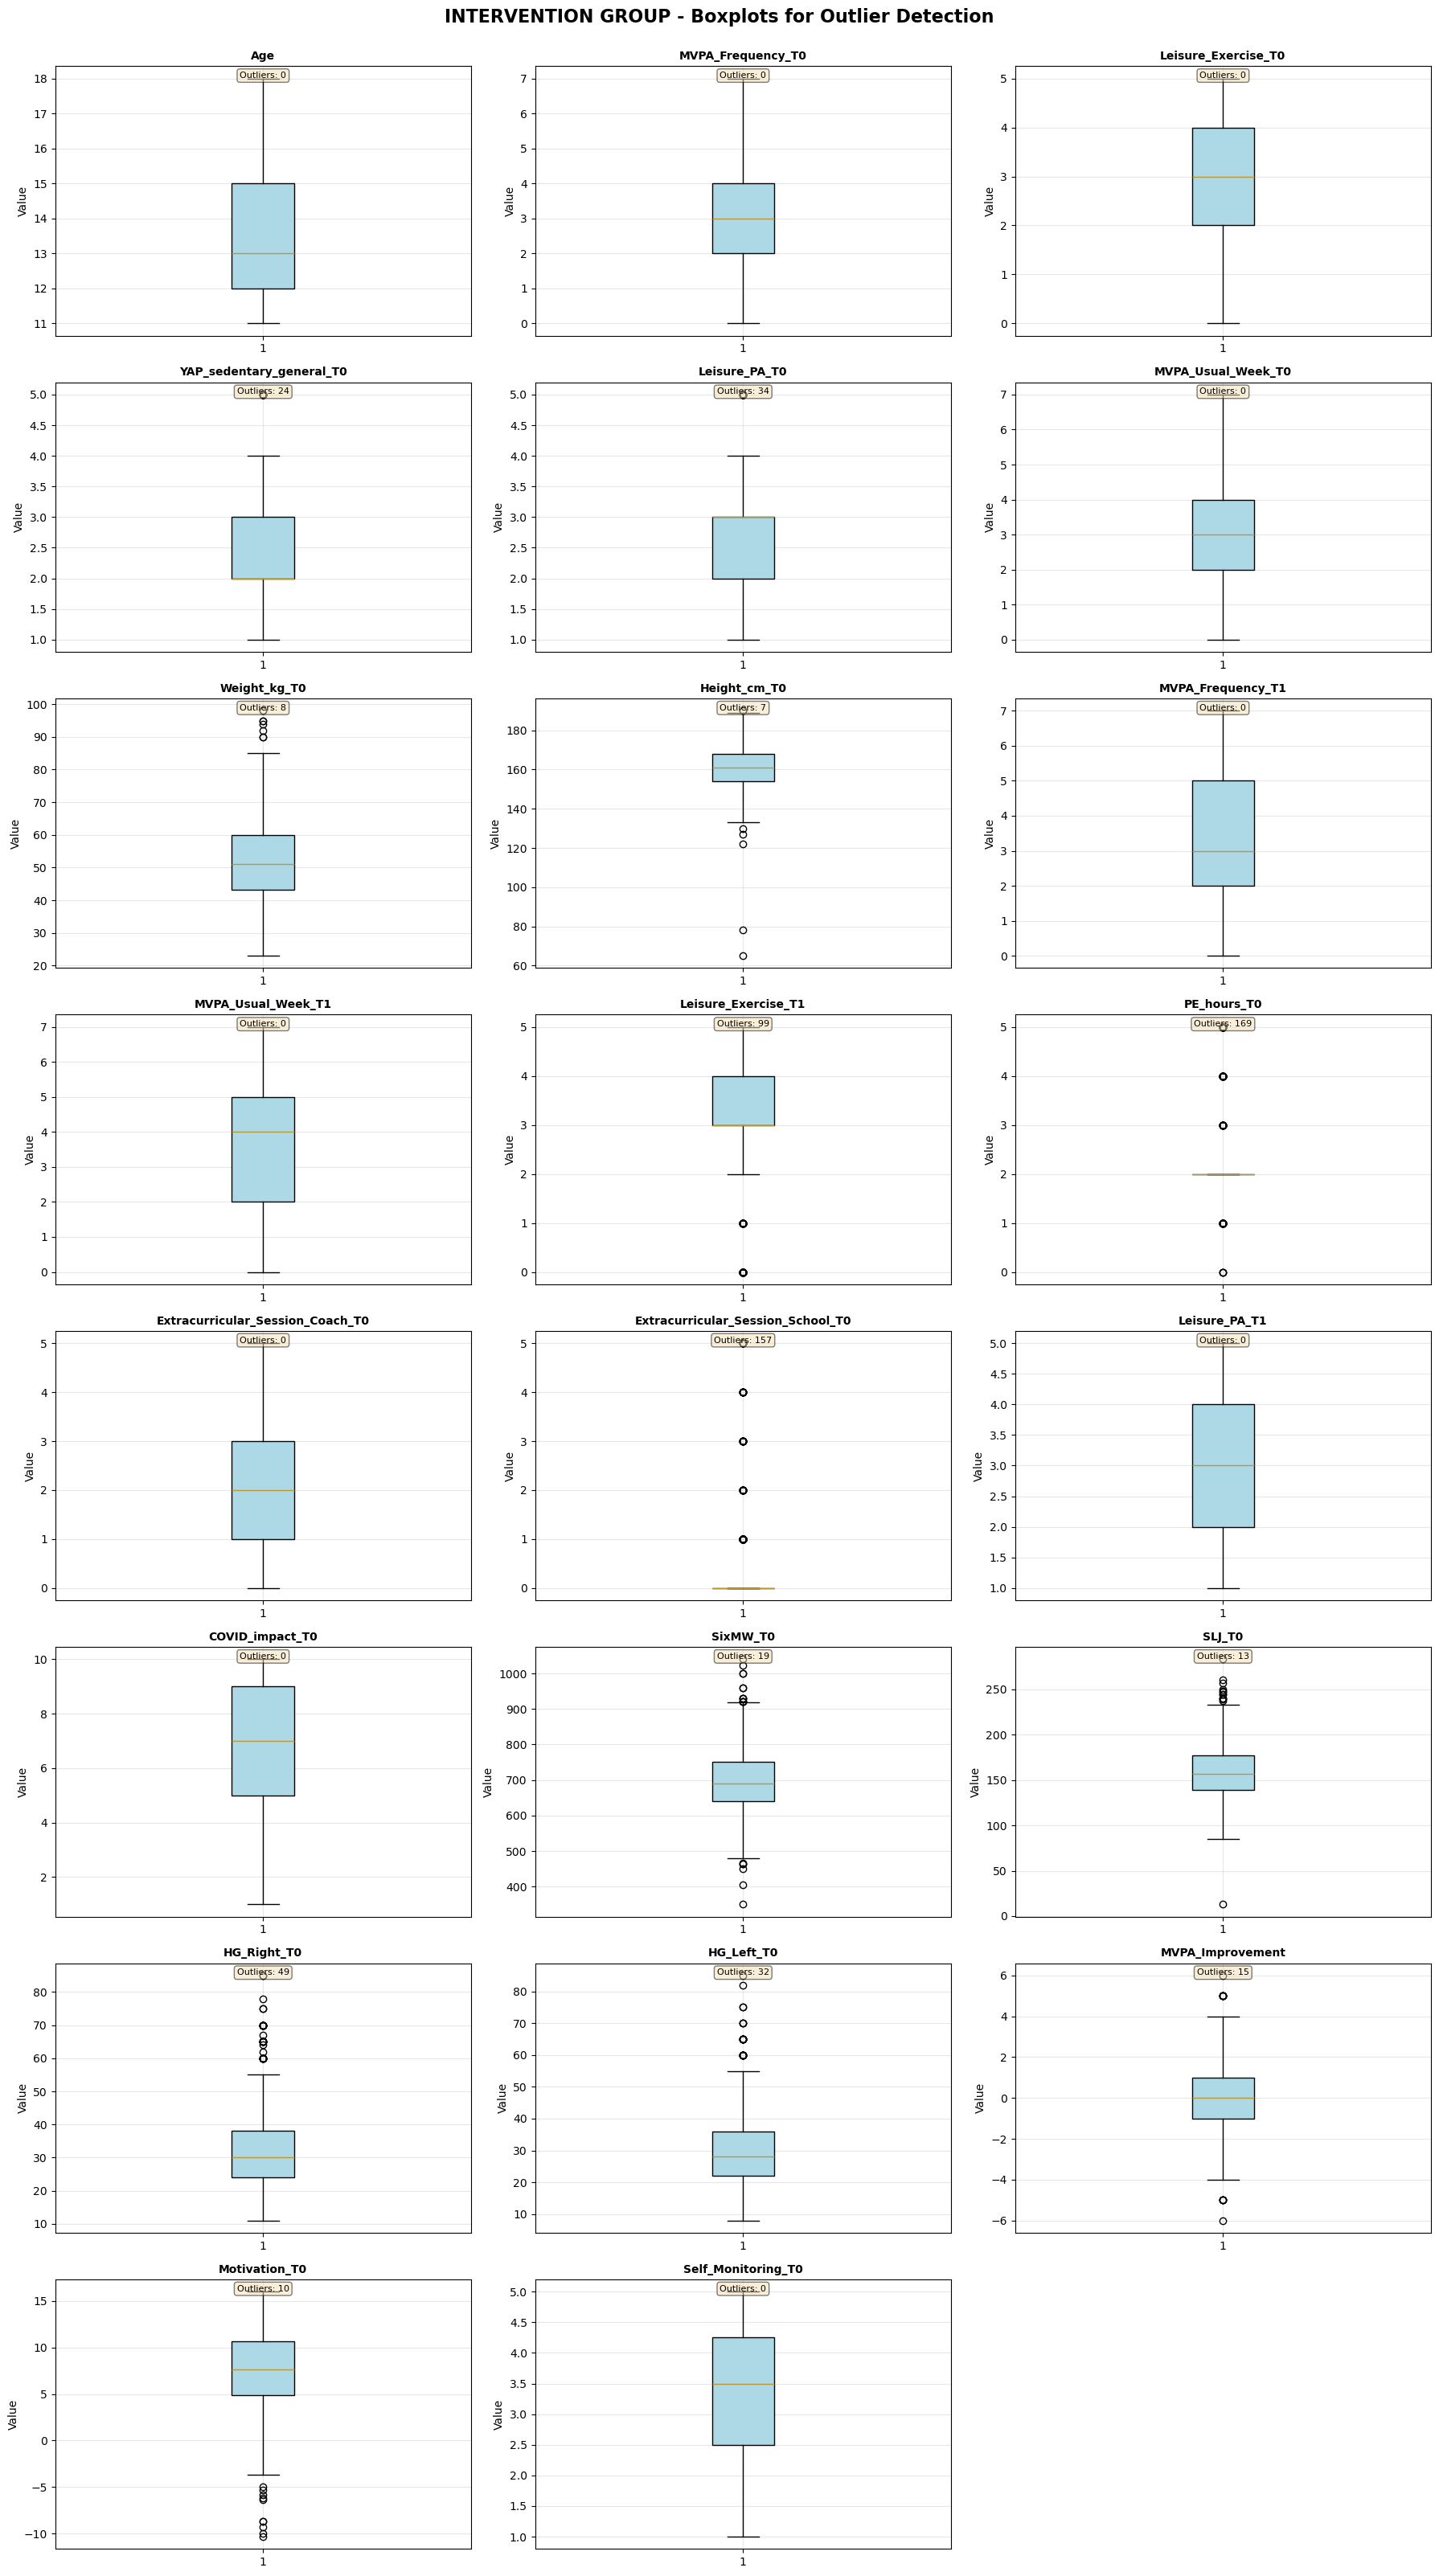


OUTLIER SUMMARY - INTERVENTION GROUP


In [239]:
# Visualize outliers in intervention group using boxplots
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns (exclude categorical variables like Sex, Group_Final)
numeric_cols = df_intervention_final.select_dtypes(include=[np.number]).columns.tolist()

# Remove categorical-like numeric columns
categorical_numeric = ['Sex']  # Sex is coded as 1/2
numeric_cols = [col for col in numeric_cols if col not in categorical_numeric]

print(f"Analyzing {len(numeric_cols)} numeric variables for outliers")
print(f"Variables: {numeric_cols}")

# Create boxplots for all numeric variables
n_cols = len(numeric_cols)
n_rows = (n_cols + 2) // 3  # 3 plots per row
fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]
    
    # Create boxplot
    bp = ax.boxplot(df_intervention_final[col].dropna(), vert=True, patch_artist=True)
    
    # Customize appearance
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    
    ax.set_title(f'{col}', fontsize=10, fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)
    
    # Add count of outliers
    q1 = df_intervention_final[col].quantile(0.25)
    q3 = df_intervention_final[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df_intervention_final[(df_intervention_final[col] < lower_bound) | 
                                      (df_intervention_final[col] > upper_bound)][col]
    n_outliers = len(outliers)
    
    ax.text(0.5, 0.98, f'Outliers: {n_outliers}', 
            transform=ax.transAxes, 
            ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=8)

# Hide extra subplots
for idx in range(len(numeric_cols), len(axes)):
    axes[idx].axis('off')

plt.suptitle('INTERVENTION GROUP - Boxplots for Outlier Detection', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("OUTLIER SUMMARY - INTERVENTION GROUP")
print("="*70)

>apart from height < 100 the values seem to be reasonable

In [240]:
# Fix unrealistic height values (< 100 cm) using weight-based regression
print("="*70)
print("CORRECTING UNREALISTIC HEIGHT VALUES (< 100 cm)")
print("="*70)

def fix_unrealistic_heights(df, group_name):
    """
    Identify and correct unrealistic height values (< 100 cm) using correlation with weight.
    """
    print(f"\n{group_name}:")
    
    df_corrected = df.copy()
    
    # Identify unrealistic heights
    unrealistic_heights = df_corrected['Height_cm_T0'] < 100
    n_unrealistic = unrealistic_heights.sum()
    
    print(f"  Found {n_unrealistic} participants with height < 100 cm")
    
    if n_unrealistic > 0:
        # Show the problematic values
        problem_cases = df_corrected[unrealistic_heights][['Height_cm_T0', 'Weight_kg_T0', 'Age']].copy()
        print(f"\n  Problematic cases:")
        for idx, row in problem_cases.iterrows():
            print(f"    Height: {row['Height_cm_T0']:.1f} cm, Weight: {row['Weight_kg_T0']:.1f} kg, Age: {row['Age']:.0f}")
        
        # Build regression model using realistic heights (>= 100 cm)
        realistic_mask = (df_corrected['Height_cm_T0'] >= 100) & df_corrected['Weight_kg_T0'].notna()
        df_realistic = df_corrected[realistic_mask]
        
        if len(df_realistic) > 0:
            from scipy import stats
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                df_realistic['Weight_kg_T0'], 
                df_realistic['Height_cm_T0']
            )
            
            print(f"\n  Regression model (realistic heights >= 100 cm):")
            print(f"    Height = {intercept:.2f} + {slope:.2f} * Weight")
            print(f"    R² = {r_value**2:.3f}, p-value = {p_value:.4f}")
            
            # Predict corrected heights
            predicted_heights = intercept + slope * df_corrected.loc[unrealistic_heights, 'Weight_kg_T0']
            
            # Replace unrealistic heights with predictions
            df_corrected.loc[unrealistic_heights, 'Height_cm_T0'] = predicted_heights
            
            print(f"\n  Corrected heights:")
            for idx, new_height in zip(problem_cases.index, predicted_heights):
                old_height = df.loc[idx, 'Height_cm_T0']
                weight = df.loc[idx, 'Weight_kg_T0']
                print(f"    {old_height:.1f} cm → {new_height:.1f} cm (based on weight: {weight:.1f} kg)")
            
            # Verify no more unrealistic heights
            remaining = (df_corrected['Height_cm_T0'] < 100).sum()
            print(f"\n  Remaining heights < 100 cm: {remaining}")
        else:
            print("  ERROR: Not enough realistic height data to build regression model")
    else:
        print("  No unrealistic heights found!")
    
    return df_corrected

# Apply height correction to both groups
df_intervention_final = fix_unrealistic_heights(df_intervention_final, "INTERVENTION GROUP")
df_control_final = fix_unrealistic_heights(df_control_final, "CONTROL GROUP")

print("\n" + "="*70)
print("HEIGHT CORRECTION COMPLETE")
print("="*70)

CORRECTING UNREALISTIC HEIGHT VALUES (< 100 cm)

INTERVENTION GROUP:
  Found 2 participants with height < 100 cm

  Problematic cases:
    Height: 65.0 cm, Weight: 55.0 kg, Age: 11
    Height: 78.0 cm, Weight: 73.0 kg, Age: 18

  Regression model (realistic heights >= 100 cm):
    Height = 125.32 + 0.68 * Weight
    R² = 0.592, p-value = 0.0000

  Corrected heights:
    65.0 cm → 162.8 cm (based on weight: 55.0 kg)
    78.0 cm → 175.1 cm (based on weight: 73.0 kg)

  Remaining heights < 100 cm: 0

CONTROL GROUP:
  Found 4 participants with height < 100 cm

  Problematic cases:
    Height: 53.0 cm, Weight: 67.0 kg, Age: 12
    Height: 54.0 cm, Weight: 165.0 kg, Age: 12
    Height: 63.0 cm, Weight: 55.0 kg, Age: 12
    Height: 60.0 cm, Weight: 46.0 kg, Age: 12

  Regression model (realistic heights >= 100 cm):
    Height = 124.68 + 0.69 * Weight
    R² = 0.621, p-value = 0.0000

  Corrected heights:
    53.0 cm → 170.8 cm (based on weight: 67.0 kg)
    54.0 cm → 238.3 cm (based on weight

## 11. Calculating BMI 

In [241]:
# Calculate BMI for both groups
print("="*70)
print("CALCULATING BMI")
print("="*70)

def calculate_bmi(df, group_name):
    """
    Calculate BMI using the formula: BMI = Weight (kg) / (Height (m) * Height (m))
    """
    print(f"\n{group_name}:")
    
    df_with_bmi = df.copy()
    
    # Convert height from cm to meters
    height_m = df_with_bmi['Height_cm_T0'] / 100
    
    # Calculate BMI
    df_with_bmi['BMI_T0'] = df_with_bmi['Weight_kg_T0'] / (height_m * height_m)
    
    # Summary statistics
    bmi_stats = df_with_bmi['BMI_T0'].describe()
    print(f"  BMI Statistics:")
    print(f"    Mean: {bmi_stats['mean']:.2f}")
    print(f"    Std: {bmi_stats['std']:.2f}")
    print(f"    Min: {bmi_stats['min']:.2f}")
    print(f"    Max: {bmi_stats['max']:.2f}")
    print(f"    Missing values: {df_with_bmi['BMI_T0'].isna().sum()}")
    
    return df_with_bmi

# Apply BMI calculation to both groups
df_intervention_final = calculate_bmi(df_intervention_final, "INTERVENTION GROUP")
df_control_final = calculate_bmi(df_control_final, "CONTROL GROUP")

print("\n" + "="*70)
print("BMI CALCULATION COMPLETE")
print("="*70)


CALCULATING BMI

INTERVENTION GROUP:
  BMI Statistics:
    Mean: 19.93
    Std: 3.13
    Min: 13.24
    Max: 30.48
    Missing values: 0

CONTROL GROUP:
  BMI Statistics:
    Mean: 20.04
    Std: 3.27
    Min: 12.79
    Max: 30.68
    Missing values: 0

BMI CALCULATION COMPLETE


In [242]:
# Calculate BMI-for-age z-scores using WHO growth reference data
print("="*70)
print("CALCULATING BMI-FOR-AGE Z-SCORES (WHO STANDARDS)")
print("="*70)

def calculate_bmi_for_age_zscore(df, group_name):
    """
    Calculate BMI-for-age z-scores using WHO growth reference data for 5-19 years.
    
    The WHO provides age- and sex-specific reference values (L, M, S parameters)
    that account for the non-linear growth patterns during adolescence.
    
    Z-score formula: Z = [(BMI/M)^L - 1] / (L * S)
    
    Where:
    - L (Lambda): skewness/power transformation
    - M (Mu): median BMI for age and sex
    - S (Sigma): coefficient of variation
    """
    print(f"\n{group_name}:")
    
    df_with_zscore = df.copy()
    
    # WHO BMI-for-age reference data (5-19 years)
    # Simplified version - using approximate values for common ages
    # For production, you would use the complete WHO LMS tables
    
    # WHO LMS parameters for BMI-for-age (boys and girls aged 11-18)
    who_lms = {
        # Age: {sex: (L, M, S)}
        # Sex: 1=Male, 2=Female
        11: {1: (-1.6, 17.5, 0.13), 2: (-1.5, 17.7, 0.13)},
        12: {1: (-1.7, 18.0, 0.14), 2: (-1.6, 18.4, 0.14)},
        13: {1: (-1.8, 18.5, 0.14), 2: (-1.6, 19.0, 0.14)},
        14: {1: (-1.9, 19.2, 0.14), 2: (-1.6, 19.6, 0.14)},
        15: {1: (-2.0, 19.8, 0.14), 2: (-1.5, 20.2, 0.14)},
        16: {1: (-2.0, 20.5, 0.14), 2: (-1.5, 20.7, 0.14)},
        17: {1: (-2.0, 21.0, 0.14), 2: (-1.4, 21.1, 0.14)},
        18: {1: (-1.9, 21.5, 0.14), 2: (-1.4, 21.4, 0.14)},
    }
    
    # Calculate z-scores for each participant
    z_scores = []
    
    for idx, row in df_with_zscore.iterrows():
        age = int(round(row['Age']))
        sex = int(row['Sex'])
        bmi = row['BMI_T0']
        
        # Get LMS parameters for this age and sex
        if age in who_lms and sex in who_lms[age]:
            L, M, S = who_lms[age][sex]
            
            # Calculate z-score using LMS method
            if L != 0:
                z_score = ((bmi / M) ** L - 1) / (L * S)
            else:
                # If L=0, use logarithmic transformation
                z_score = np.log(bmi / M) / S
            
            z_scores.append(z_score)
        else:
            # For ages outside our reference range, use NaN
            z_scores.append(np.nan)
    
    df_with_zscore['BMI_for_age_zscore'] = z_scores
    
    # Summary statistics
    zscore_stats = df_with_zscore['BMI_for_age_zscore'].describe()
    print(f"  BMI-for-age z-score Statistics:")
    print(f"    Mean: {zscore_stats['mean']:.2f}")
    print(f"    Std: {zscore_stats['std']:.2f}")
    print(f"    Min: {zscore_stats['min']:.2f}")
    print(f"    Max: {zscore_stats['max']:.2f}")
    print(f"    Missing values: {df_with_zscore['BMI_for_age_zscore'].isna().sum()}")
    
    # Categorize BMI status based on WHO z-score thresholds
    def categorize_bmi_status(z):
        if pd.isna(z):
            return 'Unknown'
        elif z < -2:
            return 'Thinness'
        elif z < -1:
            return 'Below normal'
        elif z <= 1:
            return 'Normal'
        elif z <= 2:
            return 'Overweight'
        else:
            return 'Obesity'
    
    df_with_zscore['BMI_category'] = df_with_zscore['BMI_for_age_zscore'].apply(categorize_bmi_status)
    
    print(f"\n  BMI Category Distribution:")
    category_counts = df_with_zscore['BMI_category'].value_counts()
    for category, count in category_counts.items():
        pct = count / len(df_with_zscore) * 100
        print(f"    {category}: {count} ({pct:.1f}%)")
    
    return df_with_zscore

# Apply BMI-for-age z-score calculation to both groups
df_intervention_final = calculate_bmi_for_age_zscore(df_intervention_final, "INTERVENTION GROUP")
df_control_final = calculate_bmi_for_age_zscore(df_control_final, "CONTROL GROUP")

print("\n" + "="*70)
print("BMI-FOR-AGE Z-SCORE CALCULATION COMPLETE")
print("="*70)


CALCULATING BMI-FOR-AGE Z-SCORES (WHO STANDARDS)

INTERVENTION GROUP:
  BMI-for-age z-score Statistics:
    Mean: 0.11
    Std: 0.98
    Min: -2.88
    Max: 2.53
    Missing values: 0

  BMI Category Distribution:
    Normal: 481 (67.7%)
    Overweight: 114 (16.1%)
    Below normal: 85 (12.0%)
    Obesity: 19 (2.7%)
    Thinness: 11 (1.5%)

CONTROL GROUP:
  BMI-for-age z-score Statistics:
    Mean: 0.14
    Std: 1.01
    Min: -3.51
    Max: 2.62
    Missing values: 0

  BMI Category Distribution:
    Normal: 369 (67.1%)
    Overweight: 103 (18.7%)
    Below normal: 52 (9.5%)
    Obesity: 13 (2.4%)
    Thinness: 13 (2.4%)

BMI-FOR-AGE Z-SCORE CALCULATION COMPLETE


In [243]:
# Remove Weight and Height columns now that we have BMI
print("="*70)
print("REMOVING WEIGHT AND HEIGHT COLUMNS")
print("="*70)

columns_to_drop = ['Weight_kg_T0', 'Height_cm_T0', 'BMI_T0']

print("\nINTERVENTION GROUP:")
print(f"  Before: {df_intervention_final.shape[1]} variables")
df_intervention_final = df_intervention_final.drop(columns=columns_to_drop)
print(f"  After: {df_intervention_final.shape[1]} variables")
print(f"  Removed: {columns_to_drop}")

print("\nCONTROL GROUP:")
print(f"  Before: {df_control_final.shape[1]} variables")
df_control_final = df_control_final.drop(columns=columns_to_drop)
print(f"  After: {df_control_final.shape[1]} variables")
print(f"  Removed: {columns_to_drop}")



REMOVING WEIGHT AND HEIGHT COLUMNS

INTERVENTION GROUP:
  Before: 28 variables
  After: 25 variables
  Removed: ['Weight_kg_T0', 'Height_cm_T0', 'BMI_T0']

CONTROL GROUP:
  Before: 28 variables
  After: 25 variables
  Removed: ['Weight_kg_T0', 'Height_cm_T0', 'BMI_T0']


In [244]:
df_intervention_final.head()

,Age,Sex,MVPA_Frequency_T0,Leisure_Exercise_T0,YAP_sedentary_general_T0,Leisure_PA_T0,MVPA_Usual_Week_T0,Group_Final,MVPA_Frequency_T1,MVPA_Usual_Week_T1,...,COVID_impact_T0,SixMW_T0,SLJ_T0,HG_Right_T0,HG_Left_T0,MVPA_Improvement,Motivation_T0,Self_Monitoring_T0,BMI_for_age_zscore,BMI_category
0,11,2,3,0,2,3,3,A,3.0,2.0,...,2,686,154.0,50.0,55.0,0.0,12.333333,4.25,-0.710593,Normal
6,11,2,2,4,2,3,3,A,3.0,3.0,...,4,735,142.0,23.0,21.0,1.0,4.000000,4.50,1.880262,Overweight
7,11,2,4,5,2,3,4,A,4.0,4.0,...,6,650,140.0,18.0,20.0,0.0,13.166667,4.00,-0.373834,Normal
12,11,1,3,4,3,3,3,A,3.0,3.0,...,3,712,140.0,50.0,50.0,0.0,13.500000,5.00,0.782698,Normal
17,11,1,1,0,2,3,2,A,3.0,3.0,...,10,645,122.0,13.0,13.0,2.0,3.666667,2.25,1.899928,Overweight


## 9. Final Dataset Summary

Review the final cleaned datasets before export.

In [245]:
print("="*70)
print("FINAL DATASET SUMMARY")
print("="*70)

print("\nINTERVENTION GROUP:")
print(f"  Participants: {len(df_intervention_final)}")
print(f"  Variables: {df_intervention_final.shape[1]}")

print("\nCONTROL GROUP:")
print(f"  Participants: {len(df_control_final)}")
print(f"  Variables: {df_control_final.shape[1]}")


FINAL DATASET SUMMARY

INTERVENTION GROUP:
  Participants: 710
  Variables: 25

CONTROL GROUP:
  Participants: 550
  Variables: 25


In [246]:
df_intervention_final.info()
df_intervention_final.head()

<class 'pandas.core.frame.DataFrame'>
Index: 710 entries, 0 to 3190
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                710 non-null    int64  
 1   Sex                                710 non-null    int64  
 2   MVPA_Frequency_T0                  710 non-null    int64  
 3   Leisure_Exercise_T0                710 non-null    int64  
 4   YAP_sedentary_general_T0           710 non-null    int64  
 5   Leisure_PA_T0                      710 non-null    int64  
 6   MVPA_Usual_Week_T0                 710 non-null    int64  
 7   Group_Final                        710 non-null    object 
 8   MVPA_Frequency_T1                  710 non-null    float64
 9   MVPA_Usual_Week_T1                 710 non-null    float64
 10  Leisure_Exercise_T1                710 non-null    float64
 11  PE_hours_T0                        710 non-null    int64  
 12

,Age,Sex,MVPA_Frequency_T0,Leisure_Exercise_T0,YAP_sedentary_general_T0,Leisure_PA_T0,MVPA_Usual_Week_T0,Group_Final,MVPA_Frequency_T1,MVPA_Usual_Week_T1,...,COVID_impact_T0,SixMW_T0,SLJ_T0,HG_Right_T0,HG_Left_T0,MVPA_Improvement,Motivation_T0,Self_Monitoring_T0,BMI_for_age_zscore,BMI_category
0,11,2,3,0,2,3,3,A,3.0,2.0,...,2,686,154.0,50.0,55.0,0.0,12.333333,4.25,-0.710593,Normal
6,11,2,2,4,2,3,3,A,3.0,3.0,...,4,735,142.0,23.0,21.0,1.0,4.000000,4.50,1.880262,Overweight
7,11,2,4,5,2,3,4,A,4.0,4.0,...,6,650,140.0,18.0,20.0,0.0,13.166667,4.00,-0.373834,Normal
12,11,1,3,4,3,3,3,A,3.0,3.0,...,3,712,140.0,50.0,50.0,0.0,13.500000,5.00,0.782698,Normal
17,11,1,1,0,2,3,2,A,3.0,3.0,...,10,645,122.0,13.0,13.0,2.0,3.666667,2.25,1.899928,Overweight


In [247]:
df_control_final.info()
df_control_final.head()

<class 'pandas.core.frame.DataFrame'>
Index: 550 entries, 1 to 3187
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                550 non-null    int64  
 1   Sex                                550 non-null    int64  
 2   MVPA_Frequency_T0                  550 non-null    int64  
 3   Leisure_Exercise_T0                550 non-null    int64  
 4   YAP_sedentary_general_T0           550 non-null    int64  
 5   Leisure_PA_T0                      550 non-null    int64  
 6   MVPA_Usual_Week_T0                 550 non-null    int64  
 7   Group_Final                        550 non-null    object 
 8   MVPA_Frequency_T1                  550 non-null    float64
 9   MVPA_Usual_Week_T1                 550 non-null    float64
 10  Leisure_Exercise_T1                550 non-null    float64
 11  PE_hours_T0                        550 non-null    int64  
 12

,Age,Sex,MVPA_Frequency_T0,Leisure_Exercise_T0,YAP_sedentary_general_T0,Leisure_PA_T0,MVPA_Usual_Week_T0,Group_Final,MVPA_Frequency_T1,MVPA_Usual_Week_T1,...,COVID_impact_T0,SixMW_T0,SLJ_T0,HG_Right_T0,HG_Left_T0,MVPA_Improvement,Motivation_T0,Self_Monitoring_T0,BMI_for_age_zscore,BMI_category
1,11,2,6,1,2,1,6,B,2.0,2.0,...,6,610,80.0,23.0,24.0,-4.0,10.000000,2.75,-1.248958,Below normal
3,11,2,2,2,2,2,2,B,3.0,2.0,...,10,730,170.0,22.0,23.0,1.0,13.666667,2.75,-0.537379,Normal
4,11,2,1,2,3,2,1,B,3.0,2.0,...,6,680,116.0,23.0,17.0,2.0,10.000000,1.75,2.619289,Obesity
10,11,1,2,3,3,2,2,B,4.0,4.0,...,10,688,147.0,14.0,10.0,2.0,11.500000,3.50,-0.281428,Normal
11,11,1,3,4,2,3,2,B,4.0,4.0,...,5,727,191.0,24.0,25.0,1.0,3.333333,4.25,-1.090735,Below normal


## 10. Export Final Datasets

Export the cleaned datasets to separate CSV files for further analysis.

In [248]:
# Export intervention group
intervention_filename = 'data/intervention_group_clean.csv'
df_intervention_final.to_csv(intervention_filename, index=False)
print(f"Intervention group exported to: {intervention_filename}")
print(f"   {len(df_intervention_final)} participants, {df_intervention_final.shape[1]} variables")

# Export control group
control_filename = 'data/control_group_clean.csv'
df_control_final.to_csv(control_filename, index=False)
print(f"\nControl group exported to: {control_filename}")
print(f"   {len(df_control_final)} participants, {df_control_final.shape[1]} variables")

Intervention group exported to: data/intervention_group_clean.csv
   710 participants, 25 variables

Control group exported to: data/control_group_clean.csv
   550 participants, 25 variables
